In [ ]:
import pandas as pd
import os 
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam 
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as k 
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [ ]:
Img_path = r"C:\Users\R1007398\Downloads\Books_AIML\MTECH\CV\CNN\Codes\Datasets\lungs_CT\2d_images"
Mask_path =  r"C:\Users\R1007398\Downloads\Books_AIML\MTECH\CV\CNN\Codes\Datasets\lungs_CT\2d_masks"
Img_height, Img_width = 32, 32
Seed= 42

In [ ]:
all_images = [x  for x in sorted(os.listdir(Img_path)) if x[-4:] == '.tif' ]
all_masks = [x  for x in sorted(os.listdir(Mask_path)) if x[-4:] == '.tif' ]
print(all_images.__len__())
print(all_masks.__len__())

267
267


In [ ]:
x_data  = np.empty((len(all_images), Img_height, Img_width), dtype= 'float32')
print(x_data.shape)
for i, name in enumerate(all_images):
  im = cv2.imread(Img_path+name, cv2.IMREAD_UNCHANGED).astype('int16').astype('float32')
  im = cv2.resize(im, dsize = (Img_width, Img_height), interpolation = cv2.INTER_LANCZOS4)
  im = (im - np.min(im)) / (np.max(im) - np.min(im))
  x_data[i] = im


y_data  = np.empty((len(all_images), Img_height, Img_width), dtype= 'float32')
print(y_data.shape)
for i, name in enumerate(all_images):
  im = cv2.imread(Mask_path+name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
  im = cv2.resize(im, dsize = (Img_width, Img_height), interpolation = cv2.INTER_NEAREST)
  y_data[i] = im

(267, 32, 32)
(267, 32, 32)


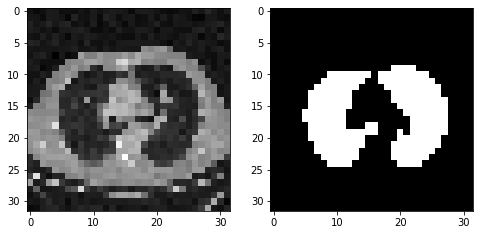

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap = 'gray')
plt.show()

In [ ]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
print(x_data.shape)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size= 0.5)


(267, 32, 32, 1)


In [ ]:
print(x_train.shape)

(133, 32, 32, 1)


In [ ]:
def dice_coef(y_true, y_pred):
  y_true_f = k.flatten(y_true)
  y_pred_f = k.flatten(y_pred)
  intersection = k.sum(y_true_f * y_pred_f)
  return (2. * intersection + k.epsilon())/(k.sum(y_true_f) + k.sum(y_pred_f) +k.epsilon())

In [ ]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=64, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size = (2,2))(c4), c3], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size = (2,2))(l), c2], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size = (2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
model = Model(input_layer, output_layer)


In [ ]:
def my_generator(X_train, y_train, batch_size):
  data_generator = ImageDataGenerator(
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      rotation_range =10,
      zoom_range=0.1).flow(x_train, x_train, batch_size, seed=Seed)


  mask_generator = ImageDataGenerator(
       width_shift_range = 0.1,
      height_shift_range = 0.1,
      rotation_range =10,
      zoom_range=0.1).flow(y_train, y_train, batch_size, seed=Seed)


  while True:
    x_batch, _ = data_generator.next()
    y_batch, _ = mask_generator.next()
    yield x_batch, y_batch

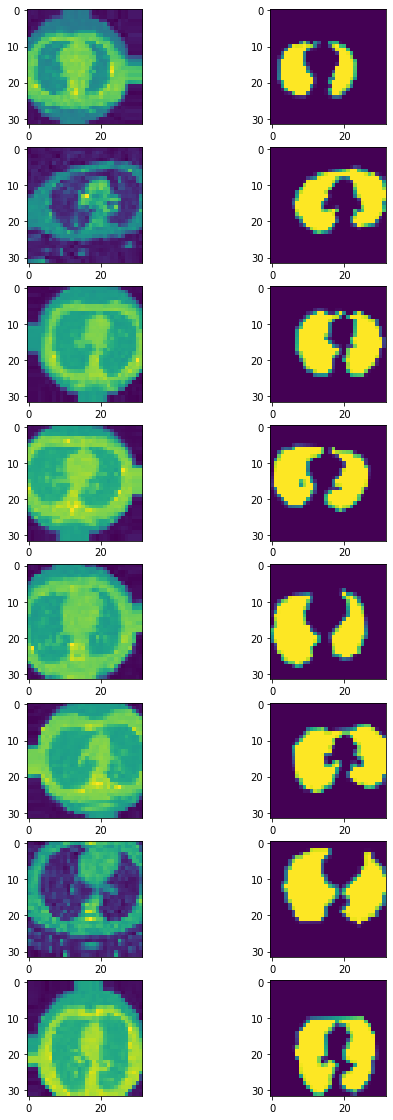

In [ ]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8, 20))
for i in range(8):
  ax[i,0].imshow(image_batch[i,:,:,0])
  ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [ ]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[IOU])

In [ ]:
weight_saver = ModelCheckpoint('lung.h5', monitor='val_IOU', 
                                              save_best_only=True, save_weights_only=True)
anneler = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [ ]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_test, y_test),
                           epochs=10, verbose=2,
                           callbacks = [weight_saver, anneler])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
200/200 - 29s - loss: 0.3509 - dice_coef: 0.5446 - val_loss: 0.2097 - val_dice_coef: 0.7643
Epoch 2/10
200/200 - 10s - loss: 0.1722 - dice_coef: 0.7958 - val_loss: 0.1315 - val_dice_coef: 0.8323
Epoch 3/10
200/200 - 10s - loss: 0.1570 - dice_coef: 0.8171 - val_loss: 0.1123 - val_dice_coef: 0.8473
Epoch 4/10
200/200 - 10s - loss: 0.1473 - dice_coef: 0.8299 - val_loss: 0.0972 - val_dice_coef: 0.8636
Epoch 5/10
200/200 - 10s - loss: 0.1431 - dice_coef: 0.8362 - val_loss: 0.0922 - val_dice_coef: 0.8680
Epoch 6/10
200/200 - 10s - loss: 0.1401 - dice_coef: 0.8380 - val_loss: 0.0894 - val_dice_coef: 0.8738
Epoch 7/10
200/200 - 10s - loss: 0.1353 - dice_coef: 0.8429 - val_loss: 0.0870 - val_dice_coef: 0.8784
Epoch 8/10
200/200 - 10s - loss: 0.1355 - dice_coef: 0.8437 - val_loss: 0.0864 - val_dice_coef: 0.8755
Epoch 9/10
200/200 - 10s - loss: 0.1333 - dice_coef: 0.8469 - val_loss: 0.0851 - val_dice_coef: 0.8779
Epoch 10/10
200/200 - 10s - loss: 0.1326 - dice_coef: 0.8474 - val_loss: 

In [ ]:
model.load_weights('lung.h5')

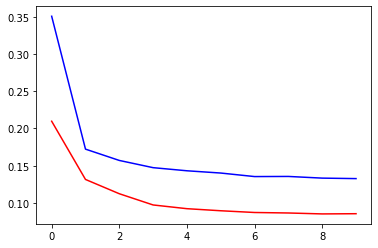

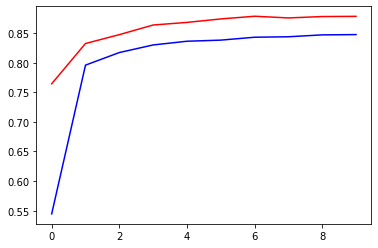

In [ ]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['IOU'], color='b')
plt.plot(hist.history['IOU'], color='r')
plt.show()

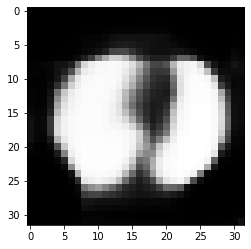

In [ ]:
plt.imshow(model.predict(x_train[0].reshape(1,Img_height, Img_width, 1))[0,:,:,0], cmap='gray')

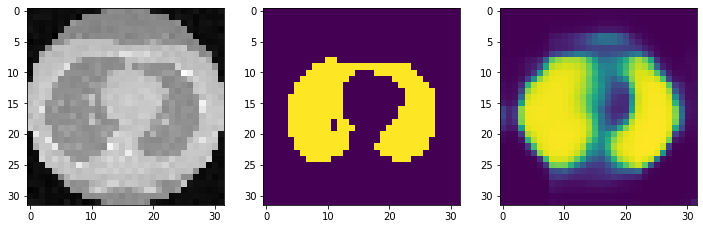

In [ ]:
y_hat = model.predict(x_test)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_test[0,:,:,0], cmap='gray')
ax[1].imshow(y_test[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])